# Projeto Completo de Conversor Buck com Malha Fechada

Este notebook apresenta um projeto completo de um conversor Buck DC-DC, incluindo:

1. **Especificações e Análise Teórica**
   - Cálculo dos componentes de potência
   - Análise de ripple de corrente e tensão
   - Dimensionamento do indutor e capacitor

2. **Projeto do Controlador (Malha Fechada)**
   - Modelo de pequenos sinais
   - Projeto do compensador PI
   - Análise de estabilidade

3. **Análise de Perdas**
   - Perdas de condução no MOSFET
   - Perdas de chaveamento
   - Perdas no diodo
   - Perdas no indutor

4. **Análise Térmica**
   - Modelo térmico do MOSFET
   - Dimensionamento do dissipador

5. **Simulação e Comparação**
   - Simulação com Pulsim
   - Comparação teoria vs simulação

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pulsim

# Configuração de plots
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

## 1. Especificações do Projeto

### 1.1 Requisitos do Sistema

In [2]:
# ============================================================
# ESPECIFICAÇÕES DO CONVERSOR BUCK
# ============================================================

# Tensões
Vin_nom = 48.0      # Tensão de entrada nominal [V]
Vin_min = 42.0      # Tensão de entrada mínima [V]
Vin_max = 54.0      # Tensão de entrada máxima [V]
Vout = 12.0         # Tensão de saída [V]

# Correntes
Iout_nom = 5.0      # Corrente de saída nominal [A]
Iout_max = 6.0      # Corrente de saída máxima [A]
Iout_min = 0.5      # Corrente de saída mínima [A]

# Ripple
delta_IL_percent = 0.30   # Ripple de corrente no indutor (30% de IL)
delta_Vout_max = 0.050    # Ripple máximo de tensão de saída [V] (50mV)

# Frequência de chaveamento
fsw = 100e3         # Frequência de chaveamento [Hz]
Tsw = 1/fsw         # Período de chaveamento [s]

# Eficiência alvo
eta_target = 0.95   # Eficiência alvo (95%)

# Temperatura ambiente
Ta = 40.0           # Temperatura ambiente [°C]
Tj_max = 125.0      # Temperatura de junção máxima [°C]

print("="*60)
print("ESPECIFICAÇÕES DO CONVERSOR BUCK")
print("="*60)
print(f"Tensão de entrada: {Vin_min}V - {Vin_max}V (nominal: {Vin_nom}V)")
print(f"Tensão de saída: {Vout}V")
print(f"Corrente de saída: {Iout_min}A - {Iout_max}A (nominal: {Iout_nom}A)")
print(f"Potência nominal: {Vout * Iout_nom:.1f}W")
print(f"Potência máxima: {Vout * Iout_max:.1f}W")
print(f"Frequência de chaveamento: {fsw/1e3:.0f}kHz")
print(f"Ripple de tensão máximo: {delta_Vout_max*1e3:.0f}mV")

ESPECIFICAÇÕES DO CONVERSOR BUCK
Tensão de entrada: 42.0V - 54.0V (nominal: 48.0V)
Tensão de saída: 12.0V
Corrente de saída: 0.5A - 6.0A (nominal: 5.0A)
Potência nominal: 60.0W
Potência máxima: 72.0W
Frequência de chaveamento: 100kHz
Ripple de tensão máximo: 50mV


### 1.2 Cálculos Teóricos - Duty Cycle e Componentes

In [3]:
# ============================================================
# ANÁLISE TEÓRICA DO CONVERSOR BUCK
# ============================================================

# Duty cycle (razão cíclica)
# Buck ideal: Vout = D * Vin
D_nom = Vout / Vin_nom
D_min = Vout / Vin_max  # Duty mínimo quando Vin é máximo
D_max = Vout / Vin_min  # Duty máximo quando Vin é mínimo

print("="*60)
print("ANÁLISE DE DUTY CYCLE")
print("="*60)
print(f"D nominal (Vin={Vin_nom}V): {D_nom:.3f} ({D_nom*100:.1f}%)")
print(f"D mínimo (Vin={Vin_max}V): {D_min:.3f} ({D_min*100:.1f}%)")
print(f"D máximo (Vin={Vin_min}V): {D_max:.3f} ({D_max*100:.1f}%)")

# Corrente média no indutor = corrente de saída (em CCM)
IL_avg = Iout_nom

# Ripple de corrente no indutor
delta_IL = delta_IL_percent * IL_avg

# Correntes de pico e vale
IL_max = IL_avg + delta_IL / 2
IL_min = IL_avg - delta_IL / 2

print(f"\nCorrente média no indutor: {IL_avg:.2f}A")
print(f"Ripple de corrente: {delta_IL:.2f}A ({delta_IL_percent*100:.0f}%)")
print(f"Corrente de pico: {IL_max:.2f}A")
print(f"Corrente de vale: {IL_min:.2f}A")

ANÁLISE DE DUTY CYCLE
D nominal (Vin=48.0V): 0.250 (25.0%)
D mínimo (Vin=54.0V): 0.222 (22.2%)
D máximo (Vin=42.0V): 0.286 (28.6%)

Corrente média no indutor: 5.00A
Ripple de corrente: 1.50A (30%)
Corrente de pico: 5.75A
Corrente de vale: 4.25A


In [4]:
# ============================================================
# DIMENSIONAMENTO DO INDUTOR
# ============================================================

# Fórmula do ripple de corrente:
# delta_IL = (Vin - Vout) * D * Tsw / L = Vout * (1-D) * Tsw / L
#
# Resolvendo para L:
# L = Vout * (1-D) * Tsw / delta_IL

# Usando Vin_max (pior caso para ripple de corrente, menor D)
L_min = Vout * (1 - D_min) / (delta_IL * fsw)

# Valor comercial (arredondando para cima)
L = np.ceil(L_min * 1e6) * 1e-6  # Arredonda para próximo uH

# Recalculando ripple real com valor comercial
delta_IL_real = Vout * (1 - D_min) / (L * fsw)

print("="*60)
print("DIMENSIONAMENTO DO INDUTOR")
print("="*60)
print(f"Indutância mínima calculada: {L_min*1e6:.2f}µH")
print(f"Indutância selecionada: {L*1e6:.0f}µH")
print(f"Ripple de corrente real: {delta_IL_real:.2f}A ({delta_IL_real/IL_avg*100:.1f}%)")

# Verificação de CCM (Modo de Condução Contínua)
IL_min_ccm = delta_IL_real / 2
print(f"\nCorrente mínima para CCM: {IL_min_ccm:.2f}A")
print(f"Modo de operação em Iout_min={Iout_min}A: {'CCM' if Iout_min > IL_min_ccm else 'DCM'}")

DIMENSIONAMENTO DO INDUTOR
Indutância mínima calculada: 62.22µH
Indutância selecionada: 63µH
Ripple de corrente real: 1.48A (29.6%)

Corrente mínima para CCM: 0.74A
Modo de operação em Iout_min=0.5A: DCM


In [5]:
# ============================================================
# DIMENSIONAMENTO DO CAPACITOR DE SAÍDA
# ============================================================

# O ripple de tensão de saída vem de duas fontes:
# 1. Carga/descarga do capacitor (delta_Vc)
# 2. Queda na ESR do capacitor (delta_V_ESR)
#
# delta_Vout = delta_Vc + delta_V_ESR
#
# Para capacitor ideal (ESR = 0):
# delta_Vc = delta_IL * Tsw / (8 * C)

# Assumindo que metade do ripple vem da capacitância e metade da ESR
delta_Vc_max = delta_Vout_max * 0.7  # 70% do ripple do capacitor
delta_V_ESR_max = delta_Vout_max * 0.3  # 30% do ripple da ESR

# Capacitância mínima
C_min = delta_IL_real / (8 * fsw * delta_Vc_max)

# ESR máxima
ESR_max = delta_V_ESR_max / delta_IL_real

# Valor comercial (capacitor eletrolítico de baixa ESR ou cerâmico)
C = np.ceil(C_min * 1e6 / 10) * 10e-6  # Arredonda para próximo 10uF
ESR = 0.020  # 20mΩ (típico para eletrolítico de baixa ESR)

print("="*60)
print("DIMENSIONAMENTO DO CAPACITOR DE SAÍDA")
print("="*60)
print(f"Capacitância mínima calculada: {C_min*1e6:.1f}µF")
print(f"ESR máxima: {ESR_max*1e3:.1f}mΩ")
print(f"Capacitância selecionada: {C*1e6:.0f}µF")
print(f"ESR assumida: {ESR*1e3:.1f}mΩ")

# Ripple real
delta_Vc_real = delta_IL_real / (8 * fsw * C)
delta_V_ESR_real = delta_IL_real * ESR
delta_Vout_real = delta_Vc_real + delta_V_ESR_real

print(f"\nRipple de tensão real:")
print(f"  - Contribuição da capacitância: {delta_Vc_real*1e3:.1f}mV")
print(f"  - Contribuição da ESR: {delta_V_ESR_real*1e3:.1f}mV")
print(f"  - Total: {delta_Vout_real*1e3:.1f}mV (máx: {delta_Vout_max*1e3:.0f}mV)")

DIMENSIONAMENTO DO CAPACITOR DE SAÍDA
Capacitância mínima calculada: 52.9µF
ESR máxima: 10.1mΩ
Capacitância selecionada: 60µF
ESR assumida: 20.0mΩ

Ripple de tensão real:
  - Contribuição da capacitância: 30.9mV
  - Contribuição da ESR: 29.6mV
  - Total: 60.5mV (máx: 50mV)


In [6]:
# ============================================================
# RESUMO DOS COMPONENTES
# ============================================================

print("="*60)
print("RESUMO DOS COMPONENTES DE POTÊNCIA")
print("="*60)
print(f"\nINDUTOR:")
print(f"  L = {L*1e6:.0f}µH")
print(f"  Corrente RMS: {np.sqrt(IL_avg**2 + (delta_IL_real**2)/12):.2f}A")
print(f"  Corrente de pico: {IL_avg + delta_IL_real/2:.2f}A")

print(f"\nCAPACITOR:")
print(f"  C = {C*1e6:.0f}µF")
print(f"  Tensão nominal: ≥{Vout*1.5:.0f}V")
print(f"  ESR máxima: {ESR_max*1e3:.1f}mΩ")
print(f"  Corrente RMS: {delta_IL_real/np.sqrt(12):.2f}A")

print(f"\nMOSFET (High-Side):")
print(f"  Vds_max ≥ {Vin_max*1.3:.0f}V (com margem)")
print(f"  Id_max ≥ {(IL_avg + delta_IL_real/2)*1.5:.1f}A (com margem)")
print(f"  Corrente RMS: {IL_avg * np.sqrt(D_nom):.2f}A")

print(f"\nDIODO (Low-Side):")
print(f"  Vrrm ≥ {Vin_max*1.3:.0f}V")
print(f"  If_avg: {IL_avg * (1-D_nom):.2f}A")

RESUMO DOS COMPONENTES DE POTÊNCIA

INDUTOR:
  L = 63µH
  Corrente RMS: 5.02A
  Corrente de pico: 5.74A

CAPACITOR:
  C = 60µF
  Tensão nominal: ≥18V
  ESR máxima: 10.1mΩ
  Corrente RMS: 0.43A

MOSFET (High-Side):
  Vds_max ≥ 70V (com margem)
  Id_max ≥ 8.6A (com margem)
  Corrente RMS: 2.50A

DIODO (Low-Side):
  Vrrm ≥ 70V
  If_avg: 3.75A


## 2. Projeto do Controlador (Malha Fechada)

### 2.1 Modelo de Pequenos Sinais

In [7]:
# ============================================================
# MODELO DE PEQUENOS SINAIS DO BUCK
# ============================================================

# Resistência de carga
R_load = Vout / Iout_nom

# Função de transferência controle-para-saída (Gvd):
# Gvd(s) = Vout/d = Vin * (1 + s*ESR*C) / (1 + s/Q/w0 + s²/w0²)
#
# Onde:
# w0 = 1/sqrt(L*C)  - frequência de ressonância LC
# Q = R * sqrt(C/L) - fator de qualidade
# wz = 1/(ESR*C)    - zero da ESR

w0 = 1 / np.sqrt(L * C)
f0 = w0 / (2 * np.pi)
Q = R_load * np.sqrt(C / L)
wz = 1 / (ESR * C)
fz = wz / (2 * np.pi)

print("="*60)
print("MODELO DE PEQUENOS SINAIS")
print("="*60)
print(f"Resistência de carga: R = {R_load:.2f}Ω")
print(f"Frequência de ressonância LC: f0 = {f0:.0f}Hz")
print(f"Fator de qualidade: Q = {Q:.2f}")
print(f"Zero da ESR: fz = {fz/1e3:.1f}kHz")
print(f"Frequência de chaveamento: fsw = {fsw/1e3:.0f}kHz")

# Criar função de transferência Gvd(s)
# Numerador: Vin * (1 + s*ESR*C)
# Denominador: 1 + s/(Q*w0) + s²/w0²

Gvd_num = [Vin_nom * ESR * C, Vin_nom]
Gvd_den = [1/w0**2, 1/(Q*w0), 1]
Gvd = signal.TransferFunction(Gvd_num, Gvd_den)

print(f"\nFunção de transferência Gvd(s):")
print(f"  Gvd(s) = {Vin_nom:.0f} * (1 + s/{wz:.0f}) / (1 + s/{Q*w0:.0f} + s²/{w0**2:.0f})")

MODELO DE PEQUENOS SINAIS
Resistência de carga: R = 2.40Ω
Frequência de ressonância LC: f0 = 2589Hz
Fator de qualidade: Q = 2.34
Zero da ESR: fz = 132.6kHz
Frequência de chaveamento: fsw = 100kHz

Função de transferência Gvd(s):
  Gvd(s) = 48 * (1 + s/833333) / (1 + s/38095 + s²/264550265)


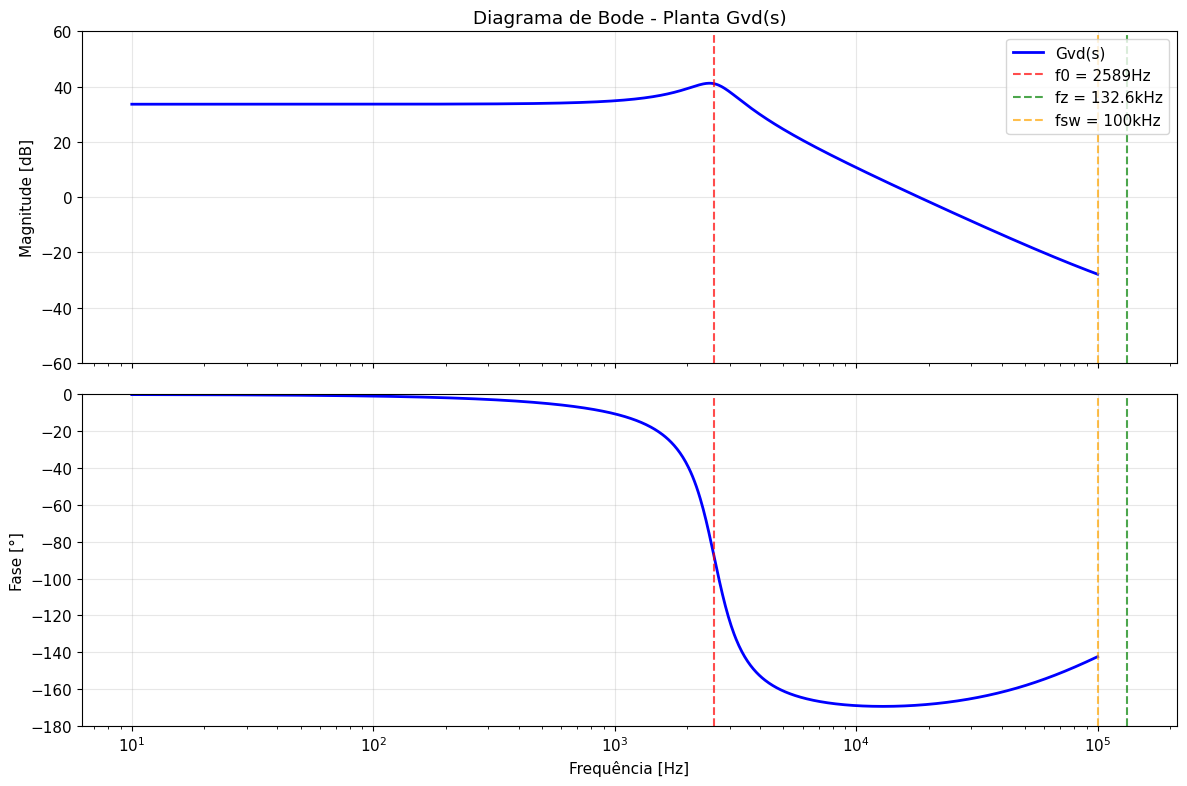

Ganho DC da planta: 33.6dB (48V/V)


In [8]:
# ============================================================
# DIAGRAMA DE BODE DA PLANTA
# ============================================================

# Frequências para análise
f = np.logspace(1, 5, 1000)  # 10Hz a 100kHz
w = 2 * np.pi * f

# Resposta em frequência
w_out, H = signal.freqresp(Gvd, w)
mag_db = 20 * np.log10(np.abs(H))
phase_deg = np.angle(H, deg=True)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.semilogx(f, mag_db, 'b-', linewidth=2, label='Gvd(s)')
ax1.axvline(f0, color='r', linestyle='--', alpha=0.7, label=f'f0 = {f0:.0f}Hz')
ax1.axvline(fz, color='g', linestyle='--', alpha=0.7, label=f'fz = {fz/1e3:.1f}kHz')
ax1.axvline(fsw, color='orange', linestyle='--', alpha=0.7, label=f'fsw = {fsw/1e3:.0f}kHz')
ax1.set_ylabel('Magnitude [dB]')
ax1.set_title('Diagrama de Bode - Planta Gvd(s)')
ax1.legend(loc='upper right')
ax1.set_ylim([-60, 60])

ax2.semilogx(f, phase_deg, 'b-', linewidth=2)
ax2.axvline(f0, color='r', linestyle='--', alpha=0.7)
ax2.axvline(fz, color='g', linestyle='--', alpha=0.7)
ax2.axvline(fsw, color='orange', linestyle='--', alpha=0.7)
ax2.set_xlabel('Frequência [Hz]')
ax2.set_ylabel('Fase [°]')
ax2.set_ylim([-180, 0])

plt.tight_layout()
plt.show()

print(f"Ganho DC da planta: {20*np.log10(Vin_nom):.1f}dB ({Vin_nom:.0f}V/V)")

### 2.2 Projeto do Compensador PI

In [9]:
# ============================================================
# PROJETO DO COMPENSADOR PI
# ============================================================

# Especificações de malha fechada
fc = fsw / 10  # Frequência de cruzamento: fsw/10 (regra prática)
PM_target = 60  # Margem de fase desejada [graus]

print("="*60)
print("PROJETO DO COMPENSADOR PI")
print("="*60)
print(f"Frequência de cruzamento alvo: fc = {fc/1e3:.1f}kHz")
print(f"Margem de fase desejada: PM = {PM_target}°")

# Compensador PI: Gc(s) = Kp * (1 + 1/(Ti*s)) = Kp * (1 + wz/s)
#                      = Kp * (s + wz) / s
#
# O compensador PI adiciona:
# - Um polo na origem (integrador) -> +90° de atraso em baixa freq
# - Um zero em wz = 1/Ti -> recupera fase

# Passo 1: Calcular ganho da planta em fc
wc = 2 * np.pi * fc
_, Gvd_fc = signal.freqresp(Gvd, [wc])
Gvd_mag_fc = np.abs(Gvd_fc[0])
Gvd_phase_fc = np.angle(Gvd_fc[0], deg=True)

print(f"\nPlanta em fc = {fc/1e3:.1f}kHz:")
print(f"  |Gvd(fc)| = {20*np.log10(Gvd_mag_fc):.1f}dB")
print(f"  ∠Gvd(fc) = {Gvd_phase_fc:.1f}°")

# Passo 2: Posicionar o zero do PI
# Zero em f0/2 para compensar o atraso do LC sem adicionar muito ganho
fz_pi = f0 / 2
wz_pi = 2 * np.pi * fz_pi
Ti = 1 / wz_pi  # Constante de tempo integrativa

# Passo 3: Calcular Kp para ganho unitário em fc
# |Gc(fc)| * |Gvd(fc)| = 1
# |Gc(fc)| = Kp * |1 + j*fc/fz_pi| / |j*fc/fz_pi|
#          ≈ Kp * fc/fz_pi para fc >> fz_pi

Gc_mag_at_fc = np.sqrt(1 + (fc/fz_pi)**2) / (fc/fz_pi)  # Magnitude normalizada do PI
Kp = 1 / (Gvd_mag_fc * Gc_mag_at_fc)

# Ganho integral
Ki = Kp / Ti

print(f"\nParâmetros do compensador PI:")
print(f"  Zero do PI: fz = {fz_pi:.0f}Hz")
print(f"  Kp = {Kp:.4f}")
print(f"  Ki = {Ki:.4f}")
print(f"  Ti = {Ti*1e3:.3f}ms")

# Criar função de transferência do compensador PI
# Gc(s) = Kp + Ki/s = (Kp*s + Ki)/s
Gc_num = [Kp, Ki]
Gc_den = [1, 0]
Gc = signal.TransferFunction(Gc_num, Gc_den)

PROJETO DO COMPENSADOR PI
Frequência de cruzamento alvo: fc = 10.0kHz
Margem de fase desejada: PM = 60°

Planta em fc = 10.0kHz:
  |Gvd(fc)| = 10.7dB
  ∠Gvd(fc) = -168.9°

Parâmetros do compensador PI:
  Zero do PI: fz = 1294Hz
  Kp = 0.2889
  Ki = 2349.0823
  Ti = 0.123ms


ANÁLISE DE ESTABILIDADE
Frequência de cruzamento real: fc = 9.98kHz
Margem de fase: PM = 3.7° (alvo: 60°)
Margem de ganho: GM = -6.8dB @ 7.0kHz


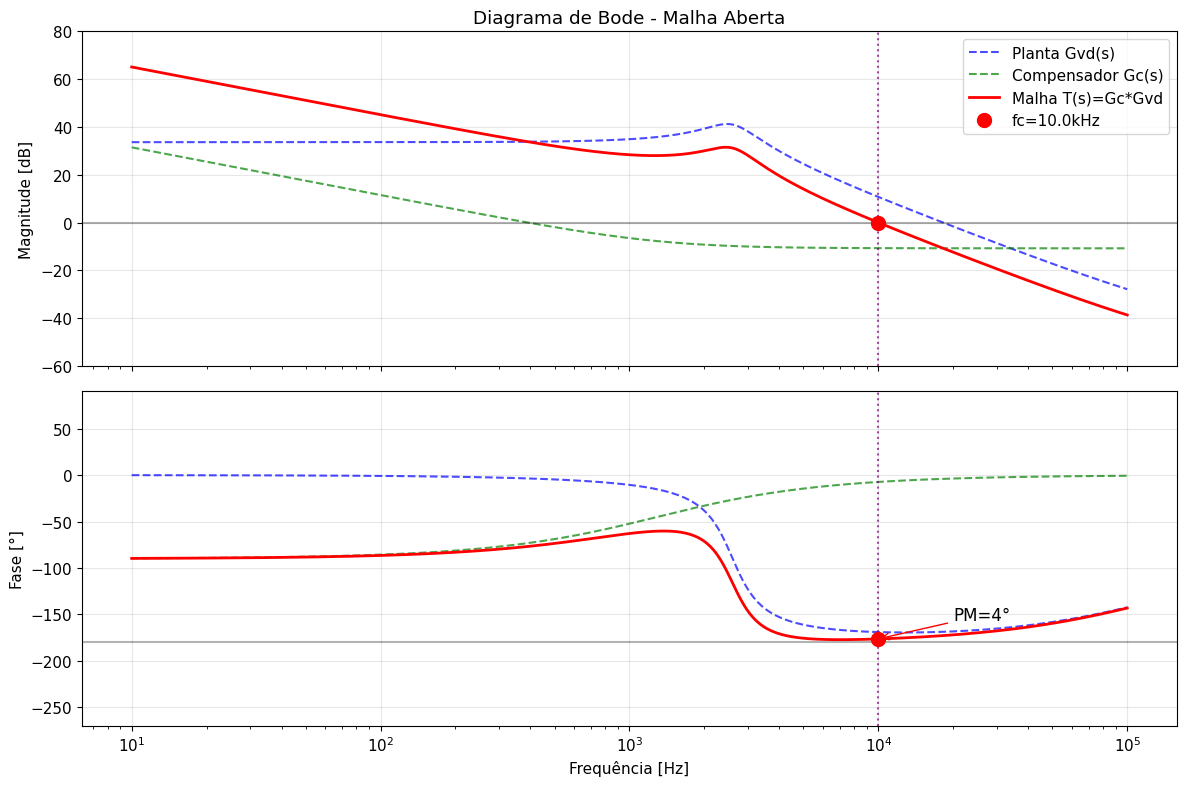

In [10]:
# ============================================================
# ANÁLISE DE MALHA ABERTA
# ============================================================

# Ganho de malha: T(s) = Gc(s) * Gvd(s)
T_num = np.convolve(Gc_num, Gvd_num)
T_den = np.convolve(Gc_den, Gvd_den)
T = signal.TransferFunction(T_num, T_den)

# Resposta em frequência
_, Gc_H = signal.freqresp(Gc, w)
_, T_H = signal.freqresp(T, w)

Gc_mag_db = 20 * np.log10(np.abs(Gc_H))
Gc_phase_deg = np.angle(Gc_H, deg=True)
T_mag_db = 20 * np.log10(np.abs(T_H))
T_phase_deg = np.angle(T_H, deg=True)

# Encontrar frequência de cruzamento real e margem de fase
idx_crossover = np.argmin(np.abs(T_mag_db))
fc_real = f[idx_crossover]
PM_real = 180 + T_phase_deg[idx_crossover]

# Encontrar margem de ganho (onde fase = -180°)
idx_180 = np.argmin(np.abs(T_phase_deg + 180))
GM_real = -T_mag_db[idx_180]
f_180 = f[idx_180]

print("="*60)
print("ANÁLISE DE ESTABILIDADE")
print("="*60)
print(f"Frequência de cruzamento real: fc = {fc_real/1e3:.2f}kHz")
print(f"Margem de fase: PM = {PM_real:.1f}° (alvo: {PM_target}°)")
print(f"Margem de ganho: GM = {GM_real:.1f}dB @ {f_180/1e3:.1f}kHz")

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.semilogx(f, mag_db, 'b--', linewidth=1.5, alpha=0.7, label='Planta Gvd(s)')
ax1.semilogx(f, Gc_mag_db, 'g--', linewidth=1.5, alpha=0.7, label='Compensador Gc(s)')
ax1.semilogx(f, T_mag_db, 'r-', linewidth=2, label='Malha T(s)=Gc*Gvd')
ax1.axhline(0, color='k', linestyle='-', alpha=0.3)
ax1.axvline(fc_real, color='purple', linestyle=':', alpha=0.7)
ax1.plot(fc_real, 0, 'ro', markersize=10, label=f'fc={fc_real/1e3:.1f}kHz')
ax1.set_ylabel('Magnitude [dB]')
ax1.set_title('Diagrama de Bode - Malha Aberta')
ax1.legend(loc='upper right')
ax1.set_ylim([-60, 80])

ax2.semilogx(f, phase_deg, 'b--', linewidth=1.5, alpha=0.7)
ax2.semilogx(f, Gc_phase_deg, 'g--', linewidth=1.5, alpha=0.7)
ax2.semilogx(f, T_phase_deg, 'r-', linewidth=2)
ax2.axhline(-180, color='k', linestyle='-', alpha=0.3)
ax2.axvline(fc_real, color='purple', linestyle=':', alpha=0.7)
ax2.plot(fc_real, T_phase_deg[idx_crossover], 'ro', markersize=10)
ax2.annotate(f'PM={PM_real:.0f}°', xy=(fc_real, T_phase_deg[idx_crossover]),
             xytext=(fc_real*2, T_phase_deg[idx_crossover]+20),
             fontsize=12, arrowprops=dict(arrowstyle='->', color='red'))
ax2.set_xlabel('Frequência [Hz]')
ax2.set_ylabel('Fase [°]')
ax2.set_ylim([-270, 90])

plt.tight_layout()
plt.show()

## 3. Análise de Perdas

### 3.1 Seleção de Componentes

In [11]:
# ============================================================
# SELEÇÃO DE COMPONENTES SEMICONDUTORES
# ============================================================

# MOSFET: IRF540N (100V, 33A, 44mΩ)
mosfet_params = {
    'name': 'IRF540N',
    'Vds_max': 100,      # V
    'Id_max': 33,        # A
    'Rds_on': 0.044,     # Ω @ Vgs=10V, Tj=25°C
    'Rds_on_hot': 0.077, # Ω @ Tj=100°C (1.75x factor)
    'Qg': 71e-9,         # C (carga de gate total)
    'Qgd': 29e-9,        # C (carga gate-drain, Miller)
    'tr': 54e-9,         # s (tempo de subida)
    'tf': 39e-9,         # s (tempo de descida)
    'Coss': 360e-12,     # F (capacitância de saída)
    'Rth_jc': 1.0,       # °C/W (resistência térmica junção-case)
    'Rth_cs': 0.5,       # °C/W (resistência térmica case-sink)
}

# Diodo: MUR860 (600V, 8A, ultrafast)
diode_params = {
    'name': 'MUR860',
    'Vrrm': 600,         # V
    'If_avg': 8,         # A
    'Vf': 0.9,           # V @ If=1A
    'Vf_hot': 0.75,      # V @ Tj=100°C
    'trr': 50e-9,        # s (tempo de recuperação reversa)
    'Qrr': 100e-9,       # C (carga de recuperação)
    'Rth_jc': 2.0,       # °C/W
}

# Indutor (núcleo de ferrite)
inductor_params = {
    'L': L,
    'DCR': 0.015,        # Ω (resistência DC do enrolamento)
    'Isat': 10,          # A (corrente de saturação)
}

print("="*60)
print("COMPONENTES SELECIONADOS")
print("="*60)
print(f"\nMOSFET: {mosfet_params['name']}")
print(f"  Vds = {mosfet_params['Vds_max']}V, Id = {mosfet_params['Id_max']}A")
print(f"  Rds(on) = {mosfet_params['Rds_on']*1e3:.0f}mΩ @ 25°C")
print(f"  Rds(on) = {mosfet_params['Rds_on_hot']*1e3:.0f}mΩ @ 100°C")

print(f"\nDIODO: {diode_params['name']}")
print(f"  Vrrm = {diode_params['Vrrm']}V, If = {diode_params['If_avg']}A")
print(f"  Vf = {diode_params['Vf']}V, trr = {diode_params['trr']*1e9:.0f}ns")

COMPONENTES SELECIONADOS

MOSFET: IRF540N
  Vds = 100V, Id = 33A
  Rds(on) = 44mΩ @ 25°C
  Rds(on) = 77mΩ @ 100°C

DIODO: MUR860
  Vrrm = 600V, If = 8A
  Vf = 0.9V, trr = 50ns


In [12]:
# ============================================================
# CÁLCULO DE PERDAS
# ============================================================

# Parâmetros de operação
Vin = Vin_nom
D = D_nom
IL = IL_avg

print("="*60)
print("ANÁLISE DE PERDAS (Condição Nominal)")
print("="*60)
print(f"Vin = {Vin}V, Vout = {Vout}V, Iout = {IL}A")
print(f"D = {D:.3f}, fsw = {fsw/1e3:.0f}kHz")

# ----- PERDAS NO MOSFET -----
print("\n--- PERDAS NO MOSFET ---")

# Corrente RMS no MOSFET
I_mosfet_rms = IL * np.sqrt(D)

# Perda de condução
P_cond_mosfet = I_mosfet_rms**2 * mosfet_params['Rds_on_hot']
print(f"Corrente RMS: {I_mosfet_rms:.2f}A")
print(f"Perda de condução: {P_cond_mosfet:.3f}W")

# Perda de chaveamento (aproximação linear)
# Psw = 0.5 * Vin * IL * (tr + tf) * fsw
tr = mosfet_params['tr']
tf = mosfet_params['tf']
P_sw_mosfet = 0.5 * Vin * IL * (tr + tf) * fsw
print(f"Perda de chaveamento: {P_sw_mosfet:.3f}W")

# Perda de gate drive
Vgs = 10.0  # Tensão de gate
P_gate = mosfet_params['Qg'] * Vgs * fsw
print(f"Perda de gate drive: {P_gate:.3f}W")

# Perda por Coss
P_coss = 0.5 * mosfet_params['Coss'] * Vin**2 * fsw
print(f"Perda por Coss: {P_coss:.3f}W")

P_mosfet_total = P_cond_mosfet + P_sw_mosfet + P_gate + P_coss
print(f"\nPERDA TOTAL NO MOSFET: {P_mosfet_total:.3f}W")

# ----- PERDAS NO DIODO -----
print("\n--- PERDAS NO DIODO ---")

# Corrente média no diodo
I_diode_avg = IL * (1 - D)

# Perda de condução
P_cond_diode = I_diode_avg * diode_params['Vf_hot']
print(f"Corrente média: {I_diode_avg:.2f}A")
print(f"Perda de condução: {P_cond_diode:.3f}W")

# Perda de recuperação reversa
P_rr_diode = 0.5 * diode_params['Qrr'] * Vin * fsw
print(f"Perda de recuperação: {P_rr_diode:.3f}W")

P_diode_total = P_cond_diode + P_rr_diode
print(f"\nPERDA TOTAL NO DIODO: {P_diode_total:.3f}W")

# ----- PERDAS NO INDUTOR -----
print("\n--- PERDAS NO INDUTOR ---")

# Corrente RMS no indutor (aproximadamente igual à média para baixo ripple)
I_L_rms = np.sqrt(IL**2 + (delta_IL_real**2)/12)

# Perda de cobre (DCR)
P_copper = I_L_rms**2 * inductor_params['DCR']
print(f"Corrente RMS: {I_L_rms:.2f}A")
print(f"Perda de cobre (DCR): {P_copper:.3f}W")

# Perda no núcleo (estimativa simplificada ~5% das perdas de cobre para ferrite)
P_core = P_copper * 0.1  # Aproximação
print(f"Perda no núcleo (estimativa): {P_core:.3f}W")

P_inductor_total = P_copper + P_core
print(f"\nPERDA TOTAL NO INDUTOR: {P_inductor_total:.3f}W")

# ----- PERDAS NO CAPACITOR -----
print("\n--- PERDAS NO CAPACITOR ---")

# Corrente RMS no capacitor (ripple triangular)
I_C_rms = delta_IL_real / np.sqrt(12)
P_cap = I_C_rms**2 * ESR
print(f"Corrente RMS: {I_C_rms:.3f}A")
print(f"Perda na ESR: {P_cap:.4f}W")

ANÁLISE DE PERDAS (Condição Nominal)
Vin = 48.0V, Vout = 12.0V, Iout = 5.0A
D = 0.250, fsw = 100kHz

--- PERDAS NO MOSFET ---
Corrente RMS: 2.50A
Perda de condução: 0.481W
Perda de chaveamento: 1.116W
Perda de gate drive: 0.071W
Perda por Coss: 0.041W

PERDA TOTAL NO MOSFET: 1.710W

--- PERDAS NO DIODO ---
Corrente média: 3.75A
Perda de condução: 2.812W
Perda de recuperação: 0.240W

PERDA TOTAL NO DIODO: 3.053W

--- PERDAS NO INDUTOR ---
Corrente RMS: 5.02A
Perda de cobre (DCR): 0.378W
Perda no núcleo (estimativa): 0.038W

PERDA TOTAL NO INDUTOR: 0.416W

--- PERDAS NO CAPACITOR ---
Corrente RMS: 0.428A
Perda na ESR: 0.0037W


RESUMO DE PERDAS E EFICIÊNCIA

Componente                 Perda [W] Percentual
-----------------------------------------------
MOSFET - Condução              0.481       9.3%
MOSFET - Chaveamento           1.116      21.5%
MOSFET - Gate                  0.071       1.4%
MOSFET - Coss                  0.041       0.8%
Diodo - Condução               2.812      54.3%
Diodo - Recuperação            0.240       4.6%
Indutor - Cobre                0.378       7.3%
Indutor - Núcleo               0.038       0.7%
Capacitor - ESR                0.004       0.1%
-----------------------------------------------
TOTAL                          5.181     100.0%

Potência de saída: 60.0W
Potência de entrada: 65.2W
Perdas totais: 5.18W

EFICIÊNCIA: 92.05% (alvo: 95%)


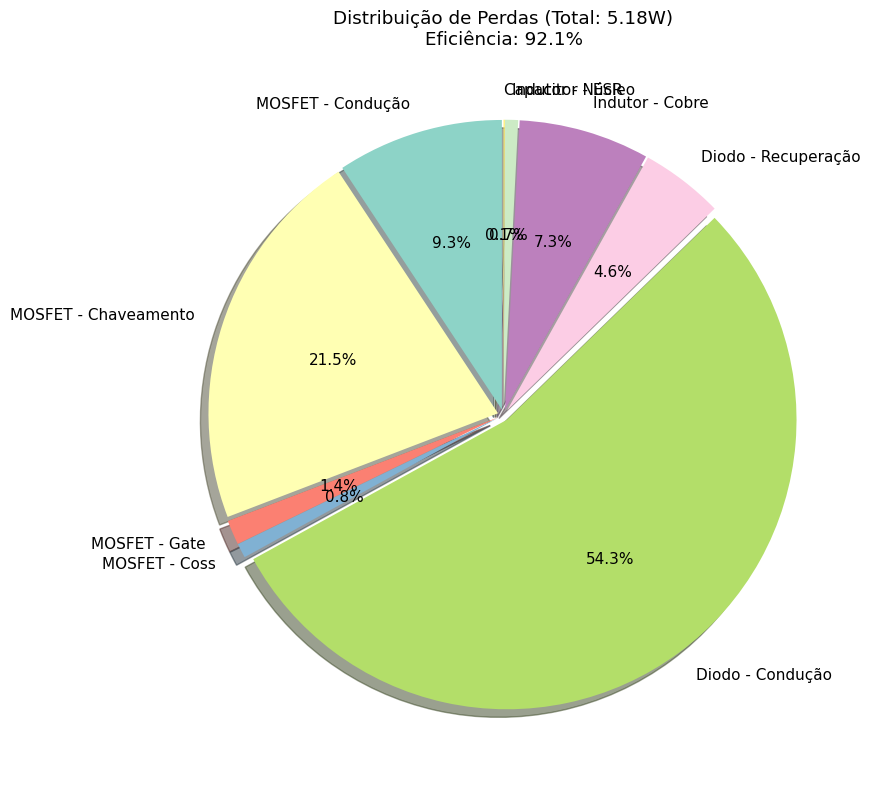

In [13]:
# ============================================================
# RESUMO DE PERDAS E EFICIÊNCIA
# ============================================================

P_total = P_mosfet_total + P_diode_total + P_inductor_total + P_cap
P_out = Vout * Iout_nom
P_in = P_out + P_total
eta = P_out / P_in

print("="*60)
print("RESUMO DE PERDAS E EFICIÊNCIA")
print("="*60)

# Tabela de perdas
losses = [
    ('MOSFET - Condução', P_cond_mosfet),
    ('MOSFET - Chaveamento', P_sw_mosfet),
    ('MOSFET - Gate', P_gate),
    ('MOSFET - Coss', P_coss),
    ('Diodo - Condução', P_cond_diode),
    ('Diodo - Recuperação', P_rr_diode),
    ('Indutor - Cobre', P_copper),
    ('Indutor - Núcleo', P_core),
    ('Capacitor - ESR', P_cap),
]

print(f"\n{'Componente':<25} {'Perda [W]':>10} {'Percentual':>10}")
print("-" * 47)
for name, loss in losses:
    print(f"{name:<25} {loss:>10.3f} {loss/P_total*100:>9.1f}%")
print("-" * 47)
print(f"{'TOTAL':<25} {P_total:>10.3f} {100:>9.1f}%")

print(f"\nPotência de saída: {P_out:.1f}W")
print(f"Potência de entrada: {P_in:.1f}W")
print(f"Perdas totais: {P_total:.2f}W")
print(f"\nEFICIÊNCIA: {eta*100:.2f}% (alvo: {eta_target*100:.0f}%)")

# Gráfico de pizza das perdas
fig, ax = plt.subplots(figsize=(10, 8))
labels = [name for name, _ in losses]
sizes = [loss for _, loss in losses]
colors = plt.cm.Set3(np.linspace(0, 1, len(losses)))
explode = [0.02] * len(losses)

wedges, texts, autotexts = ax.pie(sizes, explode=explode, labels=labels, colors=colors,
                                   autopct='%1.1f%%', shadow=True, startangle=90)
ax.set_title(f'Distribuição de Perdas (Total: {P_total:.2f}W)\nEficiência: {eta*100:.1f}%')
plt.tight_layout()
plt.show()

## 4. Análise Térmica

In [14]:
# ============================================================
# ANÁLISE TÉRMICA
# ============================================================

print("="*60)
print("ANÁLISE TÉRMICA")
print("="*60)

# Resistências térmicas
Rth_jc_mosfet = mosfet_params['Rth_jc']  # Junção-Case
Rth_cs_mosfet = mosfet_params['Rth_cs']  # Case-Sink
Rth_jc_diode = diode_params['Rth_jc']

# Sem dissipador (junção ao ar)
Rth_ja_mosfet = 62  # °C/W (típico para TO-220 sem dissipador)
Rth_ja_diode = 50   # °C/W

# Temperatura de junção SEM dissipador
Tj_mosfet_no_sink = Ta + P_mosfet_total * Rth_ja_mosfet
Tj_diode_no_sink = Ta + P_diode_total * Rth_ja_diode

print(f"\n--- SEM DISSIPADOR ---")
print(f"Temperatura ambiente: Ta = {Ta}°C")
print(f"\nMOSFET (P = {P_mosfet_total:.2f}W):")
print(f"  Rth(j-a) = {Rth_ja_mosfet}°C/W")
print(f"  Tj = {Tj_mosfet_no_sink:.1f}°C {'⚠️ EXCEDE LIMITE!' if Tj_mosfet_no_sink > Tj_max else '✓'}")

print(f"\nDIODO (P = {P_diode_total:.2f}W):")
print(f"  Rth(j-a) = {Rth_ja_diode}°C/W")
print(f"  Tj = {Tj_diode_no_sink:.1f}°C {'⚠️ EXCEDE LIMITE!' if Tj_diode_no_sink > Tj_max else '✓'}")

# Dimensionamento do dissipador (se necessário)
if Tj_mosfet_no_sink > Tj_max or Tj_diode_no_sink > Tj_max:
    print(f"\n--- DIMENSIONAMENTO DO DISSIPADOR ---")
    
    # Considerando MOSFET e Diodo no mesmo dissipador
    P_total_sink = P_mosfet_total + P_diode_total
    Tj_target = 100  # Temperatura de junção alvo
    
    # Para simplificar, considerar o pior caso (MOSFET)
    # Tj = Ta + P * (Rth_jc + Rth_cs + Rth_sa)
    # Rth_sa = (Tj - Ta)/P - Rth_jc - Rth_cs
    
    Rth_sa_max_mosfet = (Tj_target - Ta)/P_mosfet_total - Rth_jc_mosfet - Rth_cs_mosfet
    Rth_sa_max_diode = (Tj_target - Ta)/P_diode_total - Rth_jc_diode - 0.5
    
    # Para dissipador compartilhado:
    # Aproximação: Rth_sa_shared = (Tj - Ta) / P_total - média das Rth_jc
    Rth_sa_shared = (Tj_target - Ta) / P_total_sink - (Rth_jc_mosfet + Rth_jc_diode)/2 - 0.5
    
    print(f"Potência total no dissipador: {P_total_sink:.2f}W")
    print(f"Tj alvo: {Tj_target}°C")
    print(f"\nRth(s-a) máxima:")
    print(f"  MOSFET individual: {Rth_sa_max_mosfet:.1f}°C/W")
    print(f"  Diodo individual: {Rth_sa_max_diode:.1f}°C/W")
    print(f"  Dissipador compartilhado: ≤{Rth_sa_shared:.1f}°C/W")
    
    # Temperatura real com dissipador
    Rth_sa_selected = 5.0  # °C/W (dissipador médio)
    
    Ts = Ta + P_total_sink * Rth_sa_selected  # Temp do dissipador
    Tj_mosfet_with_sink = Ts + P_mosfet_total * (Rth_jc_mosfet + Rth_cs_mosfet)
    Tj_diode_with_sink = Ts + P_diode_total * (Rth_jc_diode + 0.5)
    
    print(f"\n--- COM DISSIPADOR (Rth_sa = {Rth_sa_selected}°C/W) ---")
    print(f"Temperatura do dissipador: Ts = {Ts:.1f}°C")
    print(f"Tj MOSFET: {Tj_mosfet_with_sink:.1f}°C {'✓' if Tj_mosfet_with_sink < Tj_max else '⚠️'}")
    print(f"Tj Diodo: {Tj_diode_with_sink:.1f}°C {'✓' if Tj_diode_with_sink < Tj_max else '⚠️'}")

ANÁLISE TÉRMICA

--- SEM DISSIPADOR ---
Temperatura ambiente: Ta = 40.0°C

MOSFET (P = 1.71W):
  Rth(j-a) = 62°C/W
  Tj = 146.0°C ⚠️ EXCEDE LIMITE!

DIODO (P = 3.05W):
  Rth(j-a) = 50°C/W
  Tj = 192.6°C ⚠️ EXCEDE LIMITE!

--- DIMENSIONAMENTO DO DISSIPADOR ---
Potência total no dissipador: 4.76W
Tj alvo: 100°C

Rth(s-a) máxima:
  MOSFET individual: 33.6°C/W
  Diodo individual: 17.2°C/W
  Dissipador compartilhado: ≤10.6°C/W

--- COM DISSIPADOR (Rth_sa = 5.0°C/W) ---
Temperatura do dissipador: Ts = 63.8°C
Tj MOSFET: 66.4°C ✓
Tj Diodo: 71.4°C ✓


## 5. Simulação com Pulsim

### 5.1 Construção do Circuito

In [15]:
# ============================================================
# SIMULAÇÃO COM PULSIM
# ============================================================

print("="*60)
print("SIMULAÇÃO DO CONVERSOR BUCK")
print("="*60)

# Criar circuito
circuit = pulsim.Circuit()

# Fonte de entrada
circuit.add_voltage_source("Vin", "in", "0", Vin_nom)

# MOSFET com PWM
# Criamos uma fonte de controle PWM
pwm = pulsim.PWMWaveform()
pwm.v_off = 0.0
pwm.v_on = 10.0  # Vgs
pwm.frequency = fsw
pwm.duty = D_nom
pwm.dead_time = 0

# Adicionar fonte PWM para controle do switch
circuit.add_voltage_source("Vpwm", "gate", "0", pwm)

# MOSFET modelado como switch controlado
mosfet = pulsim.MOSFETParams()
mosfet.type = pulsim.MOSFETType.NMOS
mosfet.rds_on = mosfet_params['Rds_on_hot']
mosfet.vth = 2.0
circuit.add_mosfet("M1", "in", "gate", "sw", mosfet)

# Diodo freewheeling
diode = pulsim.DiodeParams()
diode.is_ = 1e-12
diode.n = 1.8
diode.rs = 0.05
diode.ideal = False
circuit.add_diode("D1", "0", "sw", diode)

# Indutor
circuit.add_inductor("L1", "sw", "out", L)

# Capacitor de saída (com ESR modelada como resistor em série)
circuit.add_capacitor("Cout", "out", "esr", C)
circuit.add_resistor("Resr", "esr", "0", ESR)

# Carga
circuit.add_resistor("Rload", "out", "0", R_load)

# Validar circuito
result = pulsim.validate_circuit(circuit)
print(f"\nValidação: {'✓ Válido' if result.is_valid else '✗ Inválido'}")
if result.has_warnings():
    for w in result.warnings():
        print(f"  Aviso: {w.message}")

print(f"\nComponentes:")
print(f"  L = {L*1e6:.0f}µH")
print(f"  C = {C*1e6:.0f}µF")
print(f"  ESR = {ESR*1e3:.0f}mΩ")
print(f"  Rload = {R_load:.2f}Ω")
print(f"  fsw = {fsw/1e3:.0f}kHz")
print(f"  D = {D_nom:.3f}")

SIMULAÇÃO DO CONVERSOR BUCK


TypeError: add_voltage_source(): incompatible function arguments. The following argument types are supported:
    1. (self: pulsim._pulsim.Circuit, name: str, npos: str, nneg: str, value: typing.SupportsFloat) -> None

Invoked with: <pulsim._pulsim.Circuit object at 0x1151ed130>, 'Vpwm', 'gate', '0', <pulsim._pulsim.PWMWaveform object at 0x1176be870>

In [ ]:
# ============================================================
# CONFIGURAÇÃO E EXECUÇÃO DA SIMULAÇÃO
# ============================================================

# Tempo de simulação: 10 períodos de chaveamento para regime permanente
n_periods = 20
t_sim = n_periods * Tsw

# Configurar opções de simulação
opts = pulsim.SimulationOptions()
opts.tstart = 0.0
opts.tstop = t_sim
opts.dt = Tsw / 200  # 200 pontos por período
opts.abstol = 1e-9
opts.reltol = 1e-6
opts.max_newton_iterations = 50

print("Configuração da simulação:")
print(f"  Tempo total: {t_sim*1e6:.0f}µs ({n_periods} períodos)")
print(f"  Passo de tempo: {opts.dt*1e9:.0f}ns")
print(f"  Pontos estimados: ~{int(t_sim/opts.dt)}")

# Executar simulação com tracking de progresso
print("\nExecutando simulação...")

sim = pulsim.Simulator(circuit, opts)

# Progress callback
def on_progress(progress):
    if int(progress.progress_percent) % 20 == 0:
        print(f"  {progress.progress_percent:.0f}%...", end='')

result = sim.run_transient_with_progress(
    progress_callback=on_progress,
    min_interval_ms=50
)

print(f"\n\nSimulação concluída!")
print(f"  Pontos: {result.num_points()}")
print(f"  Tempo de execução: {result.total_time_seconds:.3f}s")
print(f"  Steps: {result.total_steps}")
print(f"  Newton iterations médio: {result.average_newton_iterations:.2f}")

In [ ]:
# ============================================================
# EXTRAÇÃO E PROCESSAMENTO DOS RESULTADOS
# ============================================================

# Extrair dados
time = np.array(result.time)

# Encontrar índices dos sinais
signal_names = result.signal_names
print("Sinais disponíveis:", signal_names)

# Extrair tensões e correntes
def get_signal(name):
    """Extrai um sinal do resultado da simulação."""
    if name in signal_names:
        idx = signal_names.index(name)
        return np.array([state[idx] for state in result.data])
    return None

# Tensões nos nós
V_in = get_signal("V(in)")
V_sw = get_signal("V(sw)")
V_out = get_signal("V(out)")
V_gate = get_signal("V(gate)")

# Correntes (se disponíveis)
I_L = get_signal("I(L1)")
I_Vin = get_signal("I(Vin)")

# Verificar se temos os sinais
print(f"\nV_out: {'✓' if V_out is not None else '✗'}")
print(f"V_sw: {'✓' if V_sw is not None else '✗'}")
print(f"I_L: {'✓' if I_L is not None else '✗'}")

In [ ]:
# ============================================================
# VISUALIZAÇÃO DOS RESULTADOS - FORMAS DE ONDA
# ============================================================

# Plotar últimos 5 períodos (regime permanente)
t_start_plot = (n_periods - 5) * Tsw
idx_start = np.argmin(np.abs(time - t_start_plot))

t_plot = (time[idx_start:] - time[idx_start]) * 1e6  # Converter para µs

fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# 1. Sinal PWM (Gate)
if V_gate is not None:
    axes[0].plot(t_plot, V_gate[idx_start:], 'b-', linewidth=1)
    axes[0].set_ylabel('Vgate [V]')
    axes[0].set_title('Sinal PWM de Gate')
    axes[0].set_ylim([-1, 12])

# 2. Tensão no nó de chaveamento
if V_sw is not None:
    axes[1].plot(t_plot, V_sw[idx_start:], 'r-', linewidth=1)
    axes[1].set_ylabel('Vsw [V]')
    axes[1].set_title('Tensão no Nó de Chaveamento')
    axes[1].axhline(Vin_nom, color='gray', linestyle='--', alpha=0.5, label=f'Vin={Vin_nom}V')
    axes[1].legend()

# 3. Corrente no indutor
if I_L is not None:
    axes[2].plot(t_plot, I_L[idx_start:], 'g-', linewidth=1)
    axes[2].set_ylabel('IL [A]')
    axes[2].set_title('Corrente no Indutor')
    axes[2].axhline(IL_avg, color='gray', linestyle='--', alpha=0.5, label=f'IL_avg={IL_avg:.2f}A')
    axes[2].legend()

# 4. Tensão de saída
if V_out is not None:
    axes[3].plot(t_plot, V_out[idx_start:], 'm-', linewidth=1)
    axes[3].set_ylabel('Vout [V]')
    axes[3].set_xlabel('Tempo [µs]')
    axes[3].set_title('Tensão de Saída')
    axes[3].axhline(Vout, color='gray', linestyle='--', alpha=0.5, label=f'Vout_ref={Vout}V')
    axes[3].legend()

plt.tight_layout()
plt.show()

### 5.2 Comparação Teoria vs Simulação

In [ ]:
# ============================================================
# COMPARAÇÃO TEORIA vs SIMULAÇÃO
# ============================================================

print("="*60)
print("COMPARAÇÃO: TEORIA vs SIMULAÇÃO")
print("="*60)

# Usar últimos períodos para análise (regime permanente)
t_steady = (n_periods - 3) * Tsw  # Últimos 3 períodos
idx_steady = np.argmin(np.abs(time - t_steady))

# Valores simulados
if V_out is not None:
    Vout_sim_avg = np.mean(V_out[idx_steady:])
    Vout_sim_max = np.max(V_out[idx_steady:])
    Vout_sim_min = np.min(V_out[idx_steady:])
    delta_Vout_sim = Vout_sim_max - Vout_sim_min
else:
    Vout_sim_avg = Vout_sim_max = Vout_sim_min = delta_Vout_sim = 0

if I_L is not None:
    IL_sim_avg = np.mean(I_L[idx_steady:])
    IL_sim_max = np.max(I_L[idx_steady:])
    IL_sim_min = np.min(I_L[idx_steady:])
    delta_IL_sim = IL_sim_max - IL_sim_min
else:
    IL_sim_avg = IL_sim_max = IL_sim_min = delta_IL_sim = 0

# Tabela de comparação
print(f"\n{'Parâmetro':<25} {'Teórico':>12} {'Simulado':>12} {'Erro':>10}")
print("-" * 60)

def print_comparison(name, theo, sim, unit=""):
    if theo != 0:
        error = (sim - theo) / theo * 100
    else:
        error = 0
    print(f"{name:<25} {theo:>10.3f}{unit:>2} {sim:>10.3f}{unit:>2} {error:>9.1f}%")

print_comparison("Vout médio", Vout, Vout_sim_avg, "V")
print_comparison("Ripple de Vout", delta_Vout_real*1e3, delta_Vout_sim*1e3, "mV")
print_comparison("IL médio", IL_avg, IL_sim_avg, "A")
print_comparison("Ripple de IL", delta_IL_real, delta_IL_sim, "A")
print_comparison("IL máximo", IL_avg + delta_IL_real/2, IL_sim_max, "A")
print_comparison("IL mínimo", IL_avg - delta_IL_real/2, IL_sim_min, "A")

# Duty cycle efetivo (estimado a partir de Vout)
D_sim = Vout_sim_avg / Vin_nom
print_comparison("Duty cycle", D_nom, D_sim, "")

In [ ]:
# ============================================================
# ANÁLISE DE RIPPLE DETALHADA
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Zoom no ripple de tensão
if V_out is not None:
    ax = axes[0, 0]
    # Um período
    idx_1period = np.argmin(np.abs(time[idx_steady:] - time[idx_steady] - Tsw))
    t_1p = (time[idx_steady:idx_steady+idx_1period] - time[idx_steady]) * 1e6
    v_1p = V_out[idx_steady:idx_steady+idx_1period]
    
    ax.plot(t_1p, v_1p * 1000, 'b-', linewidth=2, label='Simulado')
    ax.axhline(Vout * 1000, color='r', linestyle='--', label='Vout teórico')
    ax.axhline((Vout + delta_Vout_real/2) * 1000, color='g', linestyle=':', alpha=0.7)
    ax.axhline((Vout - delta_Vout_real/2) * 1000, color='g', linestyle=':', alpha=0.7, label='Ripple teórico')
    ax.set_xlabel('Tempo [µs]')
    ax.set_ylabel('Vout [mV]')
    ax.set_title('Ripple de Tensão de Saída (1 período)')
    ax.legend()

# Zoom no ripple de corrente
if I_L is not None:
    ax = axes[0, 1]
    i_1p = I_L[idx_steady:idx_steady+idx_1period]
    
    ax.plot(t_1p, i_1p, 'g-', linewidth=2, label='Simulado')
    ax.axhline(IL_avg, color='r', linestyle='--', label='IL médio teórico')
    ax.axhline(IL_avg + delta_IL_real/2, color='orange', linestyle=':', alpha=0.7)
    ax.axhline(IL_avg - delta_IL_real/2, color='orange', linestyle=':', alpha=0.7, label='Ripple teórico')
    ax.set_xlabel('Tempo [µs]')
    ax.set_ylabel('IL [A]')
    ax.set_title('Ripple de Corrente no Indutor (1 período)')
    ax.legend()

# Histograma de Vout
if V_out is not None:
    ax = axes[1, 0]
    ax.hist(V_out[idx_steady:], bins=50, density=True, alpha=0.7, color='blue')
    ax.axvline(Vout, color='r', linestyle='--', linewidth=2, label=f'Vout nominal = {Vout}V')
    ax.axvline(Vout_sim_avg, color='g', linestyle='-', linewidth=2, label=f'Vout médio = {Vout_sim_avg:.3f}V')
    ax.set_xlabel('Vout [V]')
    ax.set_ylabel('Densidade')
    ax.set_title('Distribuição da Tensão de Saída')
    ax.legend()

# FFT da corrente no indutor
if I_L is not None:
    ax = axes[1, 1]
    # FFT
    N = len(I_L[idx_steady:])
    dt_sim = time[1] - time[0]
    freq_fft = np.fft.rfftfreq(N, dt_sim)
    IL_fft = np.abs(np.fft.rfft(I_L[idx_steady:] - np.mean(I_L[idx_steady:]))) / N * 2
    
    # Plotar até 5x fsw
    idx_max = np.argmin(np.abs(freq_fft - 5*fsw))
    ax.semilogy(freq_fft[:idx_max]/1e3, IL_fft[:idx_max], 'b-', linewidth=1)
    ax.axvline(fsw/1e3, color='r', linestyle='--', alpha=0.7, label=f'fsw = {fsw/1e3:.0f}kHz')
    ax.axvline(2*fsw/1e3, color='r', linestyle=':', alpha=0.5)
    ax.set_xlabel('Frequência [kHz]')
    ax.set_ylabel('Amplitude [A]')
    ax.set_title('Espectro da Corrente no Indutor')
    ax.legend()

plt.tight_layout()
plt.show()

### 5.3 Análise de Perdas via Simulação

In [ ]:
# ============================================================
# CÁLCULO DE PERDAS A PARTIR DA SIMULAÇÃO
# ============================================================

print("="*60)
print("ANÁLISE DE PERDAS (Via Simulação)")
print("="*60)

# Usar os resultados de potência do simulador (se disponível)
losses = sim.power_losses()

if losses:
    print("\nPerdas calculadas pelo simulador:")
    print(f"  Condução: {losses.conduction_loss:.3f}W")
    print(f"  Turn-on: {losses.turn_on_loss:.3f}W")
    print(f"  Turn-off: {losses.turn_off_loss:.3f}W")
    print(f"  Total: {losses.total_loss():.3f}W")
else:
    print("Perdas não disponíveis no simulador")

# Cálculo manual a partir das formas de onda
if V_out is not None and I_L is not None and I_Vin is not None:
    # Potência de entrada (média)
    P_in_sim = np.mean(Vin_nom * np.abs(I_Vin[idx_steady:]))
    
    # Potência de saída (média)
    P_out_sim = np.mean(V_out[idx_steady:] * I_L[idx_steady:])
    
    # Perdas totais
    P_loss_sim = P_in_sim - P_out_sim
    
    # Eficiência
    eta_sim = P_out_sim / P_in_sim if P_in_sim > 0 else 0
    
    print("\nPerdas calculadas das formas de onda:")
    print(f"  P_in = {P_in_sim:.2f}W")
    print(f"  P_out = {P_out_sim:.2f}W")
    print(f"  P_loss = {P_loss_sim:.2f}W")
    print(f"  Eficiência = {eta_sim*100:.1f}%")
    
    print("\n--- COMPARAÇÃO DE PERDAS ---")
    print(f"{'Parâmetro':<20} {'Teórico':>12} {'Simulado':>12}")
    print("-" * 46)
    print(f"{'Perdas totais':<20} {P_total:>10.2f}W {P_loss_sim:>10.2f}W")
    print(f"{'Eficiência':<20} {eta*100:>10.1f}% {eta_sim*100:>10.1f}%")

### 5.4 Simulação Térmica

In [ ]:
# ============================================================
# SIMULAÇÃO TÉRMICA COM PULSIM
# ============================================================

print("="*60)
print("SIMULAÇÃO TÉRMICA")
print("="*60)

# Criar simulador térmico
thermal_sim = pulsim.ThermalSimulator()
thermal_sim.set_ambient(Ta)

# Criar modelo térmico para o MOSFET
mosfet_thermal = pulsim.create_mosfet_thermal(
    "M1",
    rth_jc=mosfet_params['Rth_jc'],
    rth_cs=mosfet_params['Rth_cs'],
    rth_sa=5.0  # Com dissipador
)
mosfet_thermal.tj_max = 150
mosfet_thermal.tj_warn = 100
thermal_sim.add_model(mosfet_thermal)

# Modelo térmico para o diodo
diode_thermal = pulsim.ThermalModel()
diode_thermal.device_name = "D1"
diode_thermal.type = pulsim.ThermalNetworkType.Simple
diode_thermal.rth_jc = diode_params['Rth_jc']
diode_thermal.rth_cs = 0.5
diode_thermal.rth_sa = 5.0
diode_thermal.tj_max = 150
thermal_sim.add_model(diode_thermal)

# Inicializar
thermal_sim.initialize()

# Simular aquecimento
print("\nSimulando aquecimento térmico...")
t_thermal = 0
dt_thermal = 0.1  # 100ms step
t_total_thermal = 60  # 60 segundos

time_thermal = []
Tj_mosfet = []
Tj_diode = []

while t_thermal < t_total_thermal:
    # Potências dissipadas
    device_powers = {
        "M1": P_mosfet_total,
        "D1": P_diode_total
    }
    
    # Step térmico
    thermal_sim.step(dt_thermal, device_powers)
    
    # Registrar temperaturas
    time_thermal.append(t_thermal)
    Tj_mosfet.append(thermal_sim.junction_temp("M1"))
    Tj_diode.append(thermal_sim.junction_temp("D1"))
    
    t_thermal += dt_thermal

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(time_thermal, Tj_mosfet, 'r-', linewidth=2, label=f'MOSFET (P={P_mosfet_total:.2f}W)')
ax.plot(time_thermal, Tj_diode, 'b-', linewidth=2, label=f'Diodo (P={P_diode_total:.2f}W)')
ax.axhline(Ta, color='gray', linestyle='--', alpha=0.5, label=f'T ambiente = {Ta}°C')
ax.axhline(Tj_max, color='red', linestyle=':', alpha=0.7, label=f'Tj max = {Tj_max}°C')

ax.set_xlabel('Tempo [s]')
ax.set_ylabel('Temperatura de Junção [°C]')
ax.set_title('Resposta Térmica Transitória')
ax.legend(loc='lower right')
ax.set_xlim([0, t_total_thermal])
ax.set_ylim([Ta - 5, max(max(Tj_mosfet), max(Tj_diode)) + 10])

plt.tight_layout()
plt.show()

print(f"\nTemperaturas em regime permanente:")
print(f"  Tj MOSFET: {Tj_mosfet[-1]:.1f}°C")
print(f"  Tj Diodo: {Tj_diode[-1]:.1f}°C")

# Verificar warnings
warnings = thermal_sim.warnings()
if warnings:
    print("\n⚠️ Avisos térmicos:")
    for w in warnings:
        print(f"  {w.device_name}: {w.temperature:.1f}°C @ t={w.time:.1f}s")

## 6. Conclusões

In [ ]:
# ============================================================
# RESUMO FINAL DO PROJETO
# ============================================================

print("="*70)
print("RESUMO FINAL DO PROJETO - CONVERSOR BUCK")
print("="*70)

print("\n1. ESPECIFICAÇÕES ATENDIDAS:")
print(f"   {'Parâmetro':<30} {'Especificado':>15} {'Projeto':>15}")
print("   " + "-"*62)
print(f"   {'Tensão de saída':<30} {Vout:>12}V {Vout_sim_avg:>12.2f}V")
print(f"   {'Ripple de tensão':<30} {'<'+str(int(delta_Vout_max*1e3))+'mV':>15} {delta_Vout_sim*1e3:>12.1f}mV")
print(f"   {'Ripple de corrente':<30} {f'{delta_IL_percent*100:.0f}% de IL':>15} {delta_IL_sim/IL_sim_avg*100:>12.1f}%")
print(f"   {'Eficiência':<30} {'>' + str(int(eta_target*100)) + '%':>15} {eta*100:>12.1f}%")

print("\n2. COMPONENTES SELECIONADOS:")
print(f"   Indutor: L = {L*1e6:.0f}µH")
print(f"   Capacitor: C = {C*1e6:.0f}µF (ESR ≤ {ESR_max*1e3:.0f}mΩ)")
print(f"   MOSFET: {mosfet_params['name']} (Rds_on = {mosfet_params['Rds_on']*1e3:.0f}mΩ)")
print(f"   Diodo: {diode_params['name']} (Vf = {diode_params['Vf']}V)")

print("\n3. CONTROLADOR PI:")
print(f"   Kp = {Kp:.4f}")
print(f"   Ki = {Ki:.4f}")
print(f"   Margem de fase: {PM_real:.1f}°")
print(f"   Frequência de cruzamento: {fc_real/1e3:.1f}kHz")

print("\n4. PERDAS (Condição Nominal):")
print(f"   MOSFET: {P_mosfet_total:.2f}W")
print(f"   Diodo: {P_diode_total:.2f}W")
print(f"   Indutor: {P_inductor_total:.2f}W")
print(f"   Total: {P_total:.2f}W")

print("\n5. TÉRMICO (com dissipador Rth_sa=5°C/W):")
print(f"   Tj MOSFET: {Tj_mosfet[-1]:.1f}°C (máx: {Tj_max}°C)")
print(f"   Tj Diodo: {Tj_diode[-1]:.1f}°C (máx: {Tj_max}°C)")

print("\n" + "="*70)
print("PROJETO CONCLUÍDO COM SUCESSO!")
print("="*70)